## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***

### Метрики качества генерации:

IS

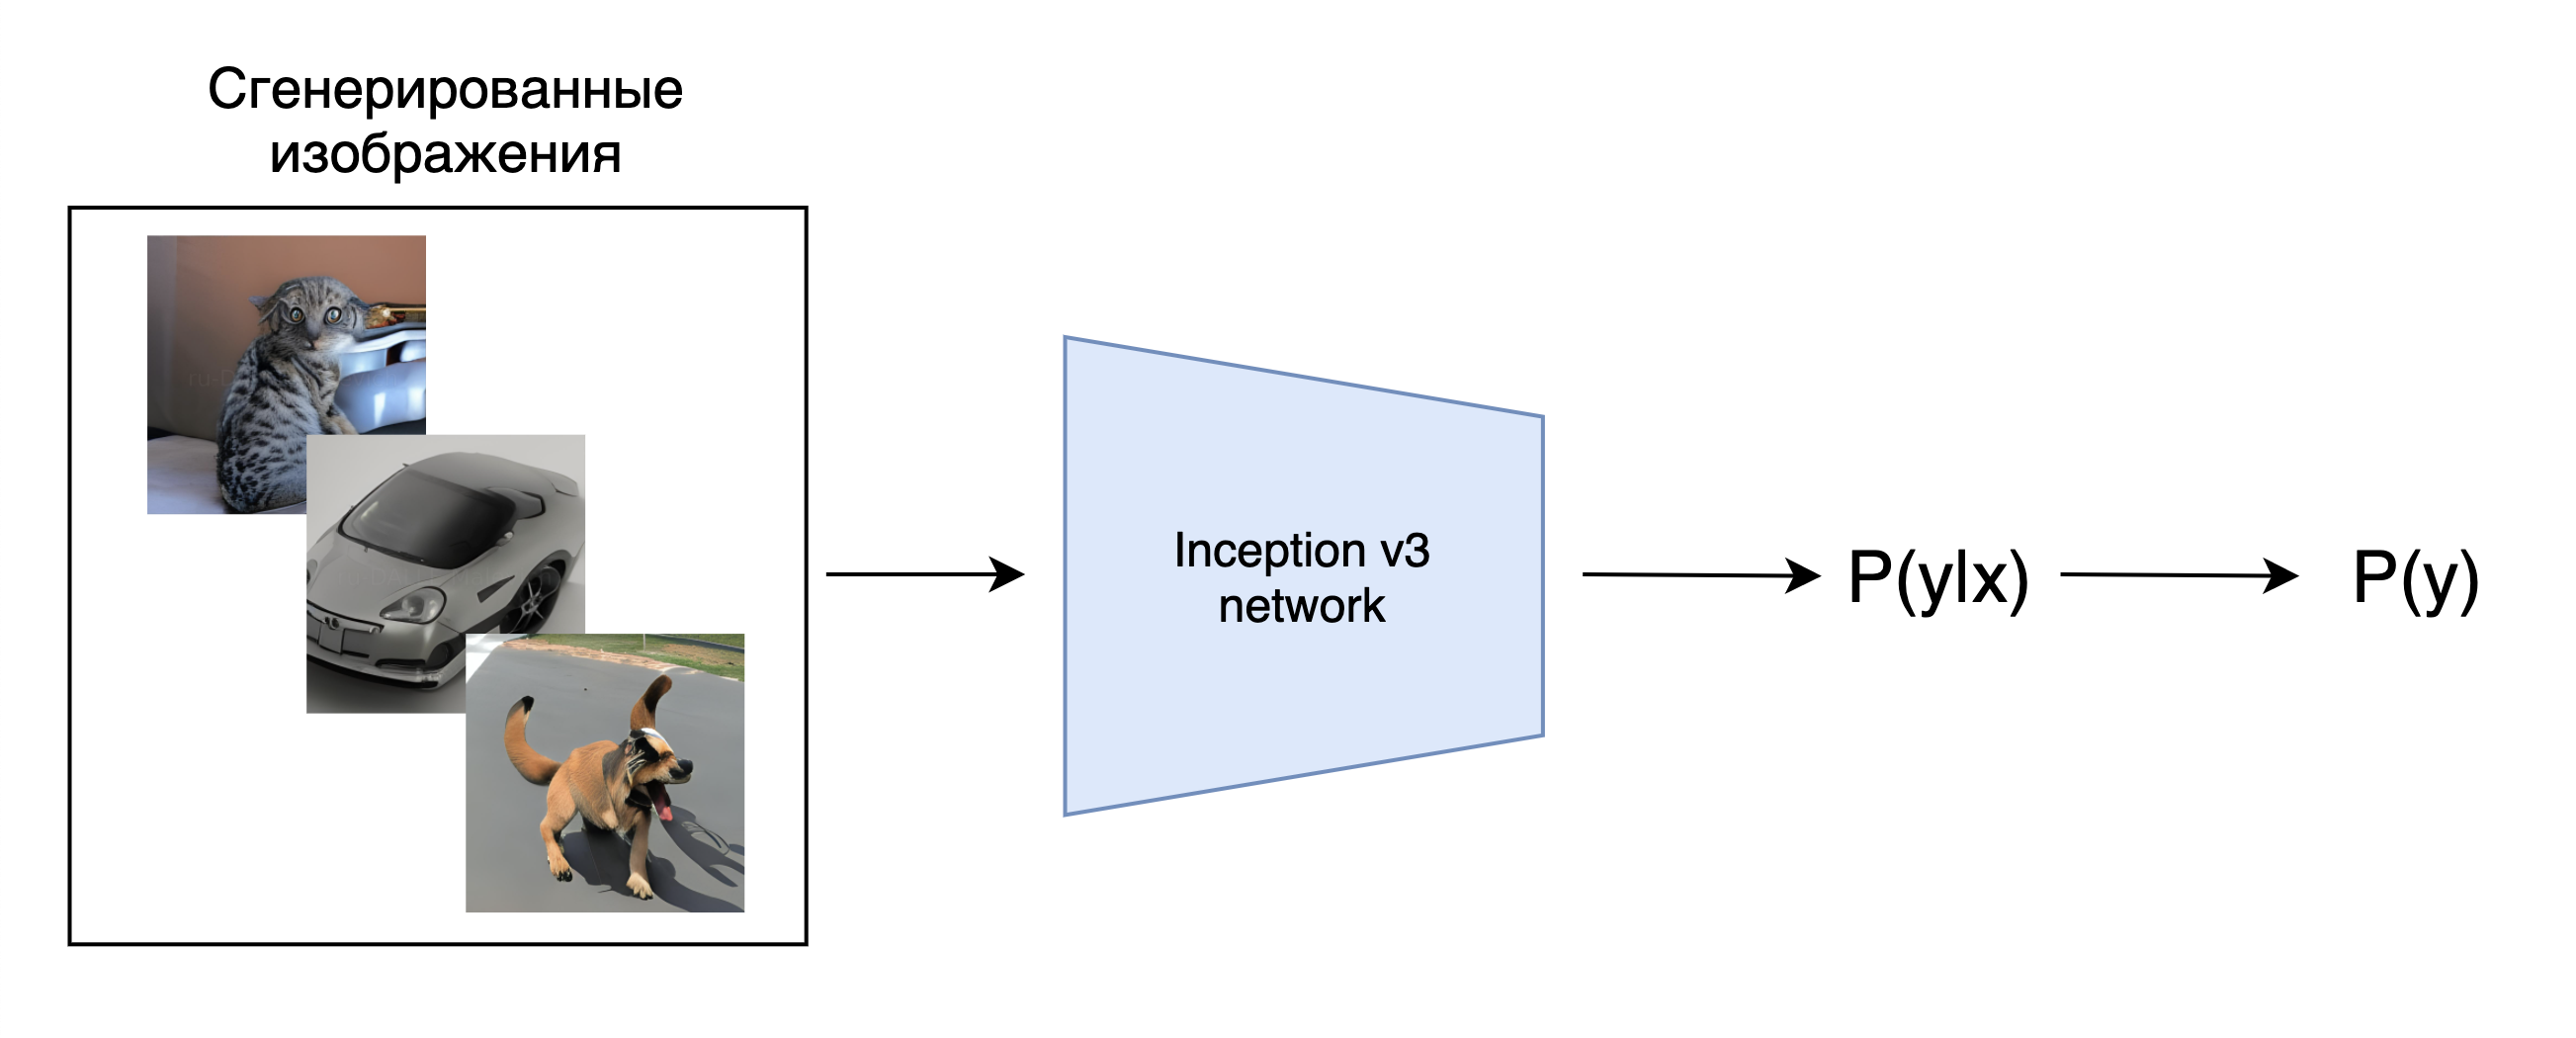

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

FID

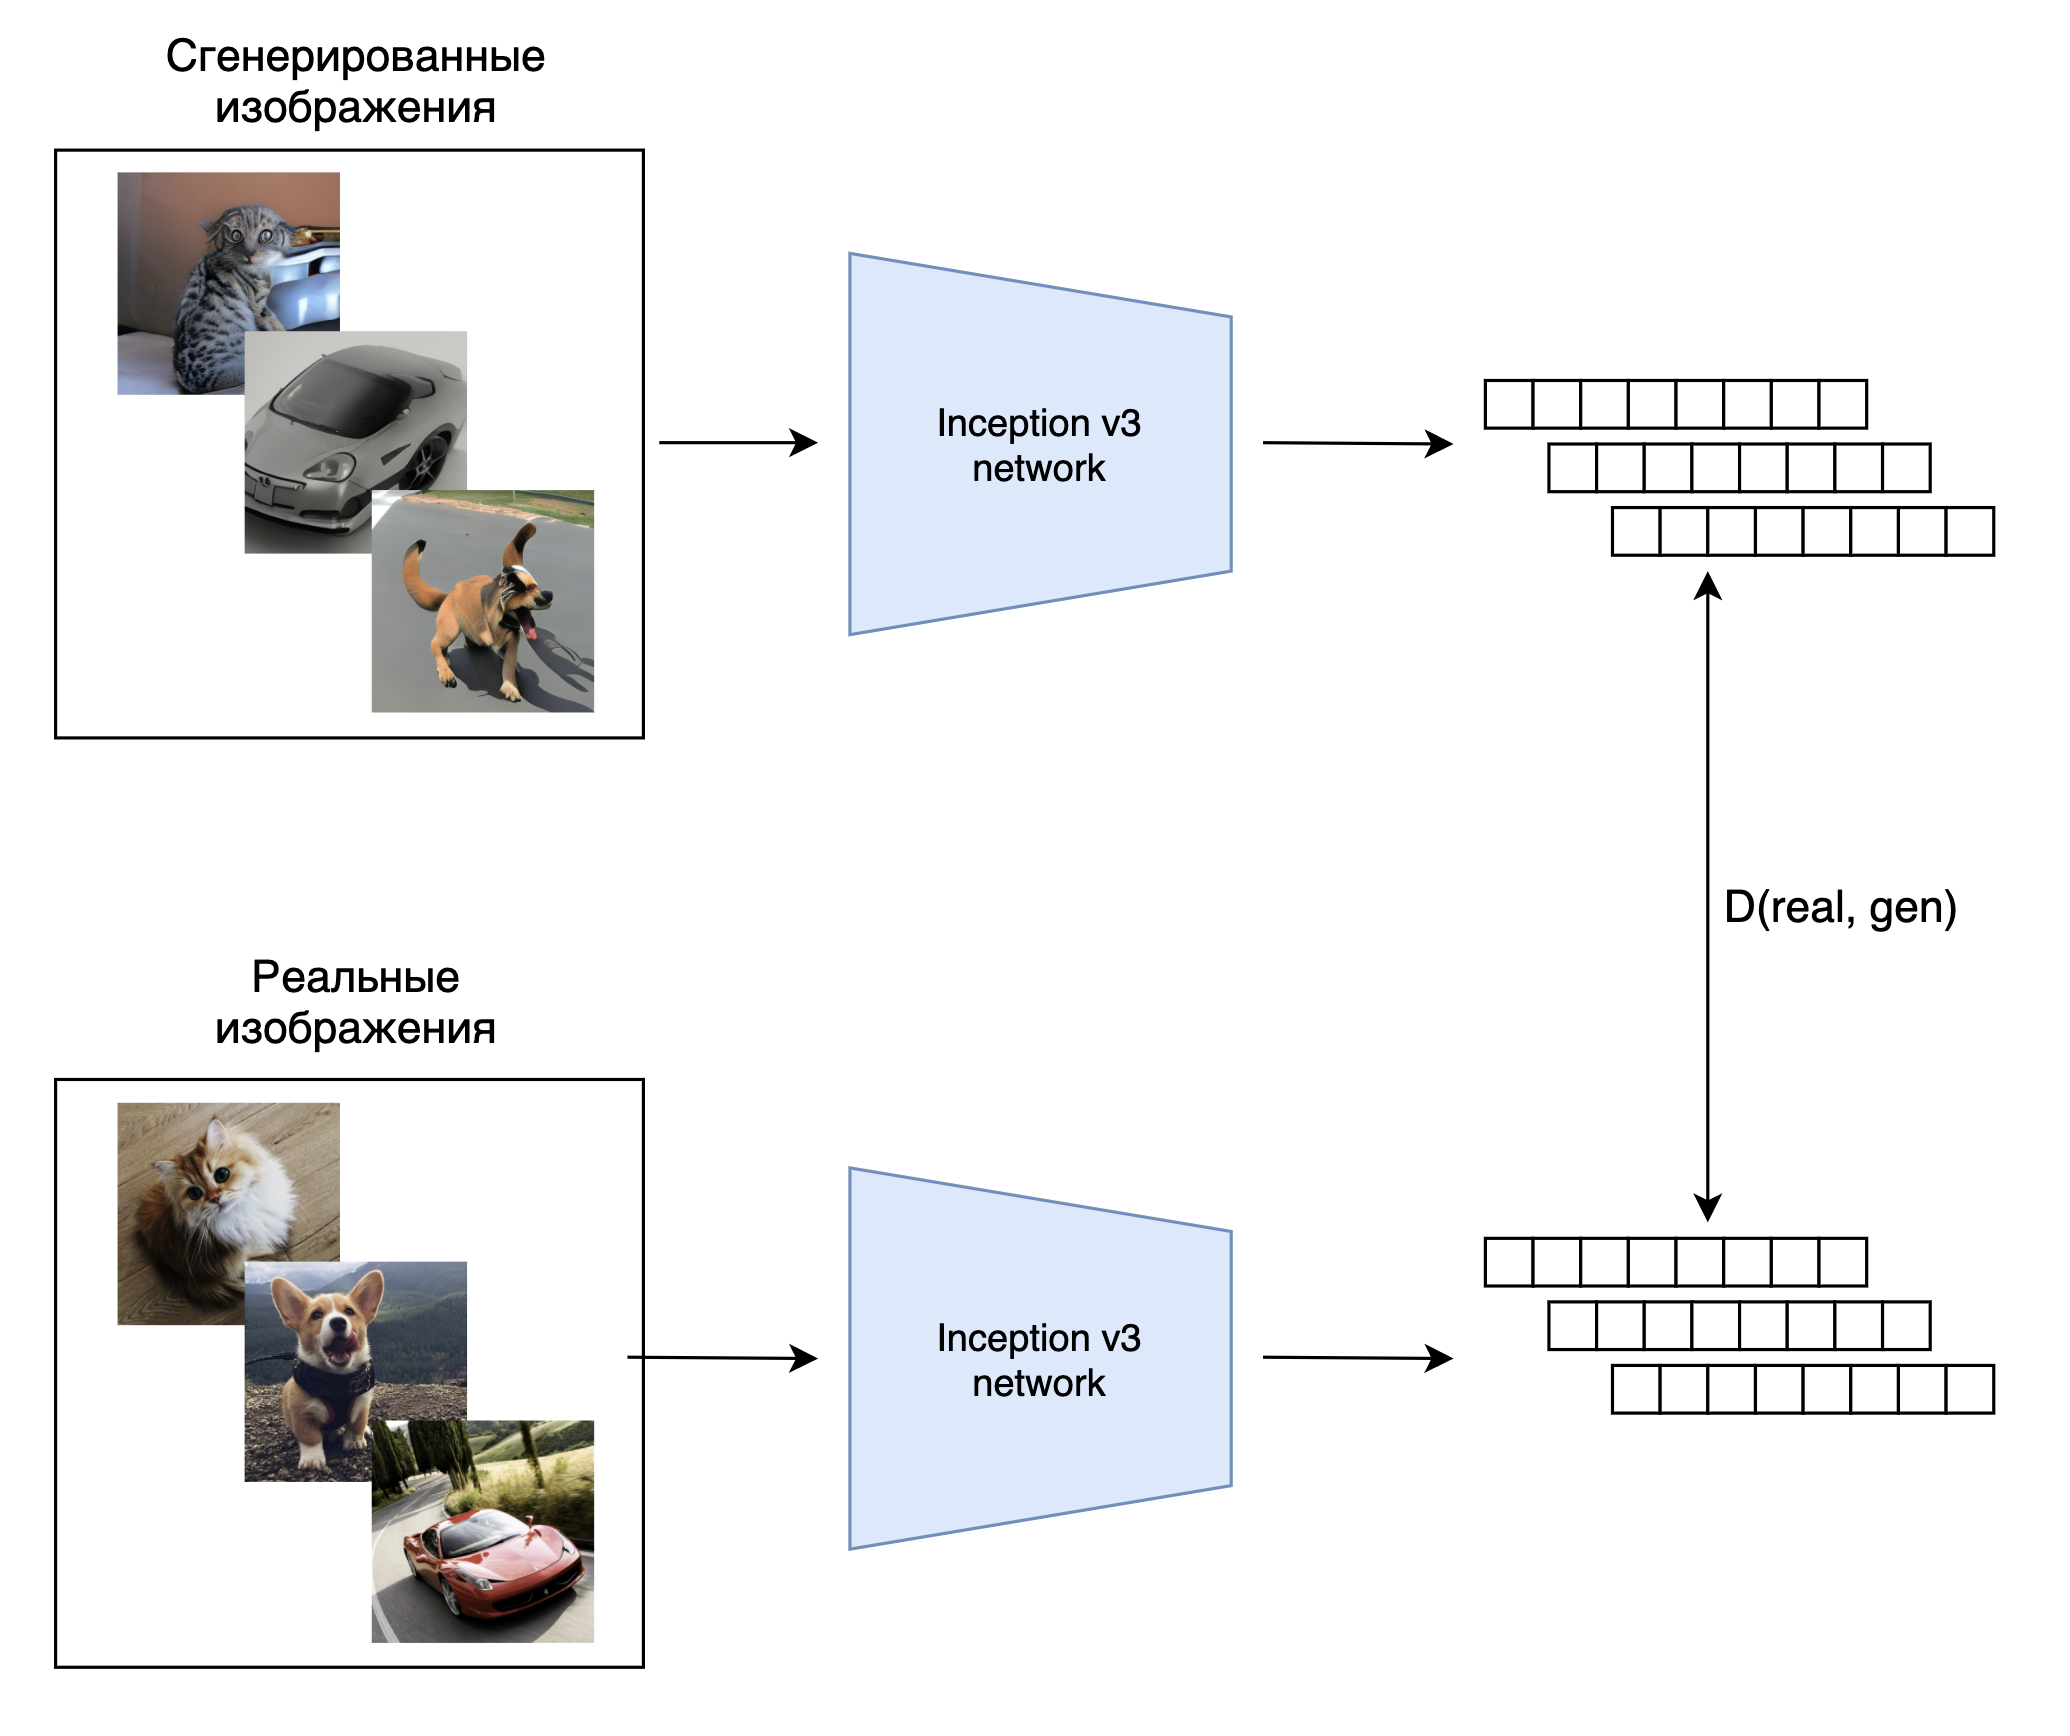

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета.


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет

* Обучить GAN на датасете CIFAR10, используя методы регуляризации: label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей без регуляризаций и с различными их комбинациями (хотя бы одной). Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
DCGAN | |
Label Smoothing (LS) |  |
Spectral Normalization (SN) |  |
DCGAN + LS + SN | |
CIFAR10 | 10.98 ± 0.22 | 3.1508

### Define parameters & Load Dataset

In [ ]:
# import torch
# import torch.nn as nn
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import torchvision
# from torchvision import transforms
# from torchvision.transforms import ToTensor, Normalize, Compose
# from torchvision.datasets import MNIST, CIFAR10
# from IPython.display import Image
# from torchvision.utils import save_image
# import os

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# print(f"Using device: {device}")

Using device: mps


In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline
plt.style.use("ggplot")



class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    # device = device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

100%|██████████| 170M/170M [00:18<00:00, 9.15MB/s]


Extracting data/cifar-10-python.tar.gz to data


Label:  6


(array([ 140.,  578., 1378., 1406., 1163., 1691., 1246., 1402., 1351.,
         602.,  440.,  344.,  279.,  185.,   83.]),
 array([-0.99215686, -0.86091501, -0.72967321, -0.59843135, -0.46718955,
        -0.33594772, -0.20470588, -0.07346405,  0.05777778,  0.18901961,
         0.32026145,  0.45150328,  0.58274508,  0.71398693,  0.84522873,
         0.97647059]),
 <BarContainer object of 15 artists>)

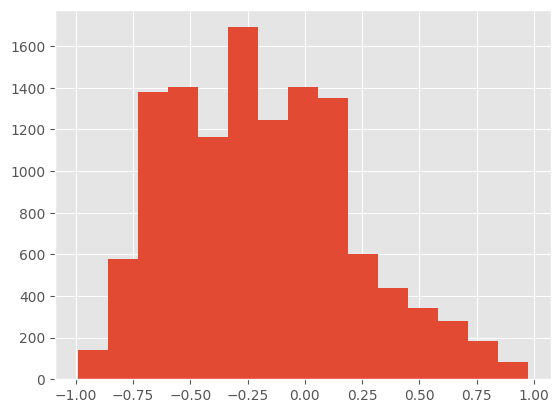

In [2]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

6


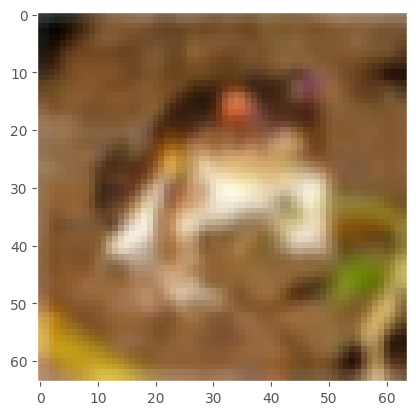

In [3]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return (x * 0.5) + 0.5

print(label)
plt.imshow(denorm(img).permute(1, 2, 0).numpy())
plt.grid()
plt.show()

In [4]:
# define the dataloader
from torch.utils.data import DataLoader

data_loader = DataLoader(
    dataset=cifar_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.workers
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Спектральная нормализация

In [5]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [6]:
import torch.nn as nn
# Generator

class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


# Discriminator
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            SpectralNorm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            SpectralNorm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [7]:
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)
# create new Discriminator model
D = Discriminator(CFG.nc, CFG.ndf).to(CFG.device)

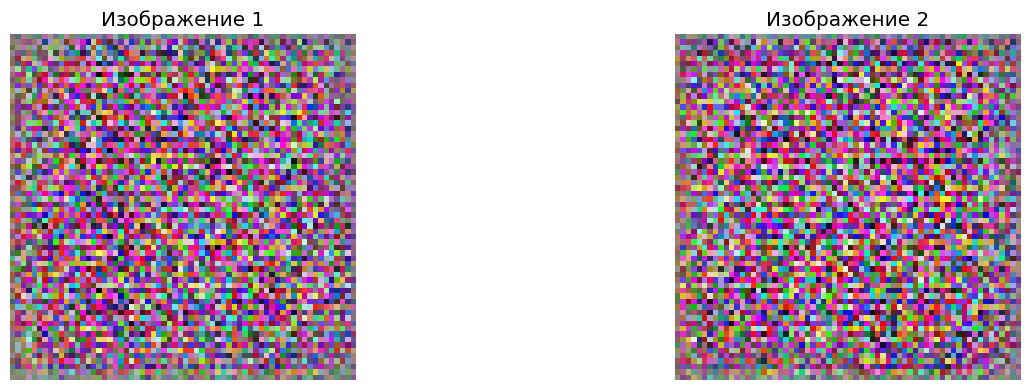

In [8]:
# show the output of model
# y = G(torch.randn(2, CFG.nz))

z = torch.randn(2, CFG.nz, 1, 1).to(CFG.device)
imgs = G(z)
imgs = [denorm(img).permute(1, 2, 0).detach().cpu() for img in imgs]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
for i, img in enumerate(imgs):
    axes[i].imshow(img)
    axes[i].set_title(f"Изображение {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

Discriminator Training

In [9]:
# feel free to reuse your training functions
import torch.optim as optim
import torch.nn.functional as F


criterion = nn.BCEWithLogitsLoss()

optimizer_G = optim.Adam(G.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
LABEL_SMOOTH = 0.95

def reset_grad():
    optimizer_G.zero_grad()
    optimizer_D.zero_grad()


def train_discriminator(real_images):
    batch_size = real_images.size(0)
    real_labels = torch.FloatTensor(batch_size).uniform_(0.7, 1.0).to(CFG.device)
    fake_labels = torch.FloatTensor(batch_size).uniform_(0.0, 0.3).to(CFG.device)

    if torch.rand(1).item() < 0.05:
        real_labels, fake_labels = fake_labels, real_labels

    real_images_noisy = real_images + 0.005 * torch.randn_like(real_images).to(CFG.device)

    outputs = D(real_images_noisy)
    d_loss_real = criterion(outputs, real_labels)
    real_score = torch.sigmoid(outputs)

    z = torch.randn(batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = G(z)

    fake_images_noisy = fake_images + 0.005 * torch.randn_like(fake_images).to(CFG.device)

    outputs = D(fake_images_noisy.detach())
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = torch.sigmoid(outputs)

    d_loss = d_loss_real + d_loss_fake

    reset_grad()
    d_loss.backward()
    optimizer_D.step()

    return d_loss, real_score, fake_score


Generator Training

In [10]:
def train_generator(batch_size):
    z = torch.randn(batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = G(z)

    labels = torch.FloatTensor(batch_size).uniform_(0.7, 1.2).to(CFG.device)

    outputs = D(fake_images)
    g_loss = criterion(outputs, labels)

    reset_grad()
    g_loss.backward()
    optimizer_G.step()

    return g_loss, fake_images

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os

root_dir = "/content/drive/MyDrive/Colab Notebooks/checkpoints"
files = os.listdir(root_dir)
print(files)


['checkpoint_epoch_70.pth', 'checkpoint_epoch_100.pth', 'checkpoint_epoch_50.pth', 'checkpoint_epoch_110.pth', 'checkpoint_epoch_130.pth', 'checkpoint_epoch_10.pth', 'checkpoint_epoch_30.pth', 'checkpoint_epoch_20.pth', 'checkpoint_epoch_80.pth', 'checkpoint_epoch_120.pth', 'checkpoint_epoch_90.pth', 'checkpoint_epoch_140.pth', 'checkpoint_epoch_60.pth', 'checkpoint_epoch_40.pth']


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [15]:
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_epoch_140.pth")

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

    G.load_state_dict(checkpoint["generator_state_dict"])
    D.load_state_dict(checkpoint["discriminator_state_dict"])

    optimizer_G.load_state_dict(checkpoint["optimizer_G_state_dict"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D_state_dict"])

    start_epoch = checkpoint["epoch"]
    d_losses = checkpoint["d_losses"]
    g_losses = checkpoint["g_losses"]
    real_scores = checkpoint["real_scores"]
    fake_scores = checkpoint["fake_scores"]

    print(f"Checkpoint loaded! Resuming from epoch {start_epoch}")
else:
    print("No checkpoint found. Starting from scratch.")
    start_epoch = 0

Loading checkpoint from /content/drive/MyDrive/Colab Notebooks/checkpoints/checkpoint_epoch_140.pth...


<ipython-input-15-d760e75f387f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))  # or 'cuda' if y

Checkpoint loaded! Resuming from epoch 140


## Start the training process

In [16]:
import os
from torchvision.utils import save_image

sample_dir = 'samples'
os.makedirs(sample_dir, exist_ok=True)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def save_fake_images(index):
    z = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = G(z)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [17]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10
    )

In [18]:
import os
print(os.getcwd())

/content


In [19]:
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
%%time
import torch
import os
from tqdm import tqdm

# Восстановление параметров из чекпоинта
start_epoch = checkpoint["epoch"]
d_losses = checkpoint["d_losses"]
g_losses = checkpoint["g_losses"]
real_scores = checkpoint["real_scores"]
fake_scores = checkpoint["fake_scores"]
print(f"Checkpoint loaded! Resuming from epoch {start_epoch}")

# Восстанавливаем модель и оптимизаторы
G.load_state_dict(checkpoint["generator_state_dict"])
D.load_state_dict(checkpoint["discriminator_state_dict"])
optimizer_G.load_state_dict(checkpoint["optimizer_G_state_dict"])
optimizer_D.load_state_dict(checkpoint["optimizer_D_state_dict"])

device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size
total_step = len(data_loader)

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}...")

    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)
        batch_size = images.size(0)

        try:
            print(f"Step {i + 1}/{total_step}: Training discriminator...")
            d_loss, real_score, fake_score = train_discriminator(images)
            print(f"Discriminator done! d_loss={d_loss.item():.4f}")

            print(f"Step {i + 1}/{total_step}: Training generator...")
            g_loss, fake_images = train_generator(batch_size)
            print(f"Generator done! g_loss={g_loss.item():.4f}")

        except Exception as e:
            print(f"Error at step {i + 1}: {e}")
            break

        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())

            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], "
                  f"d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, "
                  f"D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}")

    save_fake_images(epoch + 1)
    print(f"Saved fake images for epoch {epoch + 1}!\n")

    if (epoch + 1) % 10 == 0:
        checkpoint = {
            "epoch": epoch + 1,
            "generator_state_dict": G.state_dict(),
            "discriminator_state_dict": D.state_dict(),
            "optimizer_G_state_dict": optimizer_G.state_dict(),
            "optimizer_D_state_dict": optimizer_D.state_dict(),
            "d_losses": d_losses,
            "g_losses": g_losses,
            "real_scores": real_scores,
            "fake_scores": fake_scores,
        }
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}.pth")
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1}")

print("Training complete!")


Выходные данные были обрезаны до нескольких последних строк (5000).
Step 320/391: Training generator...
Generator done! g_loss=0.4539
Step 321/391: Training discriminator...
Discriminator done! d_loss=1.0852
Step 321/391: Training generator...
Generator done! g_loss=1.0476
Step 322/391: Training discriminator...
Discriminator done! d_loss=1.0362
Step 322/391: Training generator...
Generator done! g_loss=1.0074
Step 323/391: Training discriminator...
Discriminator done! d_loss=1.0289
Step 323/391: Training generator...
Generator done! g_loss=0.8347
Step 324/391: Training discriminator...
Discriminator done! d_loss=2.5778
Step 324/391: Training generator...
Generator done! g_loss=0.9581
Step 325/391: Training discriminator...
Discriminator done! d_loss=0.9919
Step 325/391: Training generator...
Generator done! g_loss=0.8443
Step 326/391: Training discriminator...
Discriminator done! d_loss=0.9029
Step 326/391: Training generator...
Generator done! g_loss=1.1170
Step 327/391: Training dis

In [22]:
import shutil
from google.colab import files

# Путь к папке
folder_path = "/content/samples"

# Создание архива
shutil.make_archive("samples", "zip", folder_path)

# Скачивание архива
files.download("samples.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

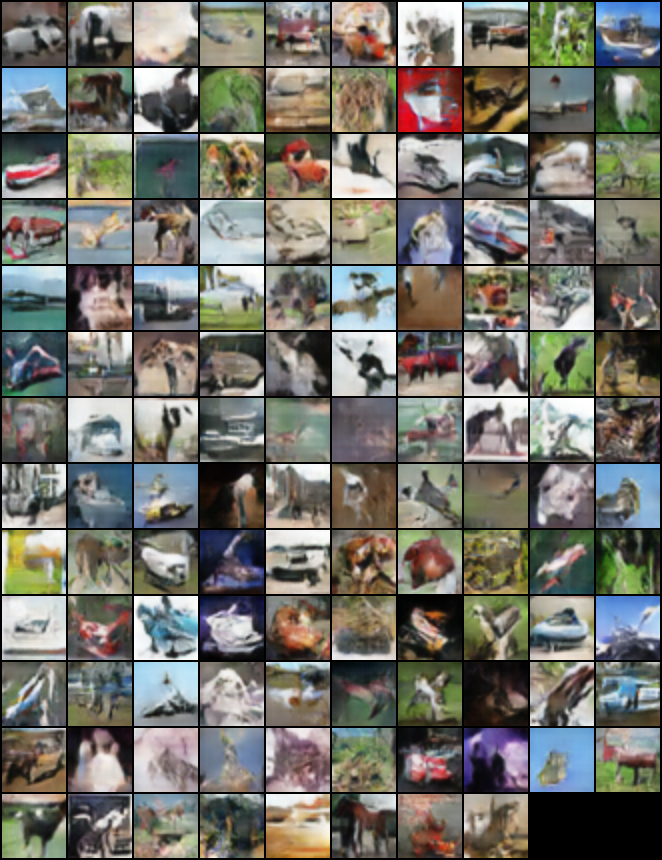

In [26]:
from IPython.display import Image
sample_dir = '/content/drive/MyDrive/Colab Notebooks/samples'

image_path = os.path.join(sample_dir, 'fake_images-0125.png')
Image(filename=image_path)

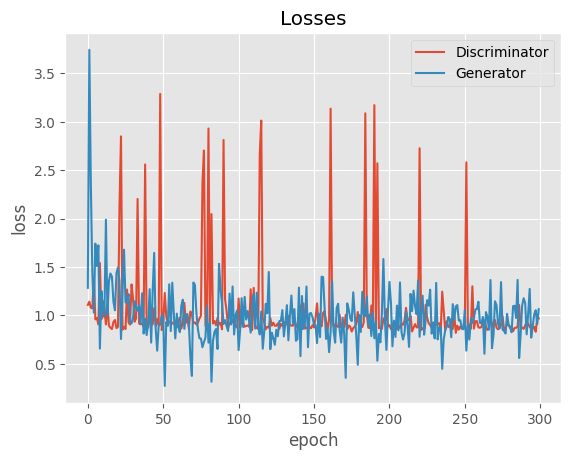

In [27]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

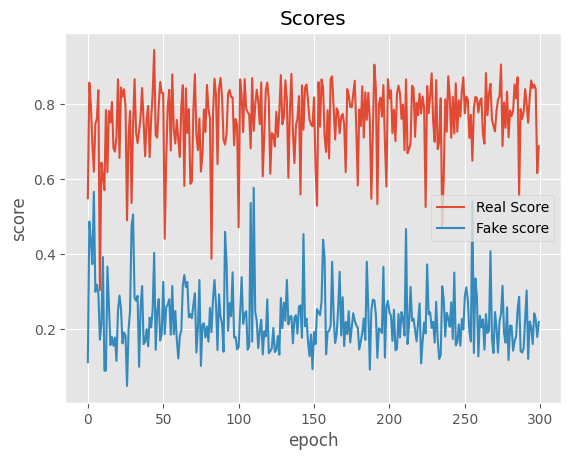

In [28]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

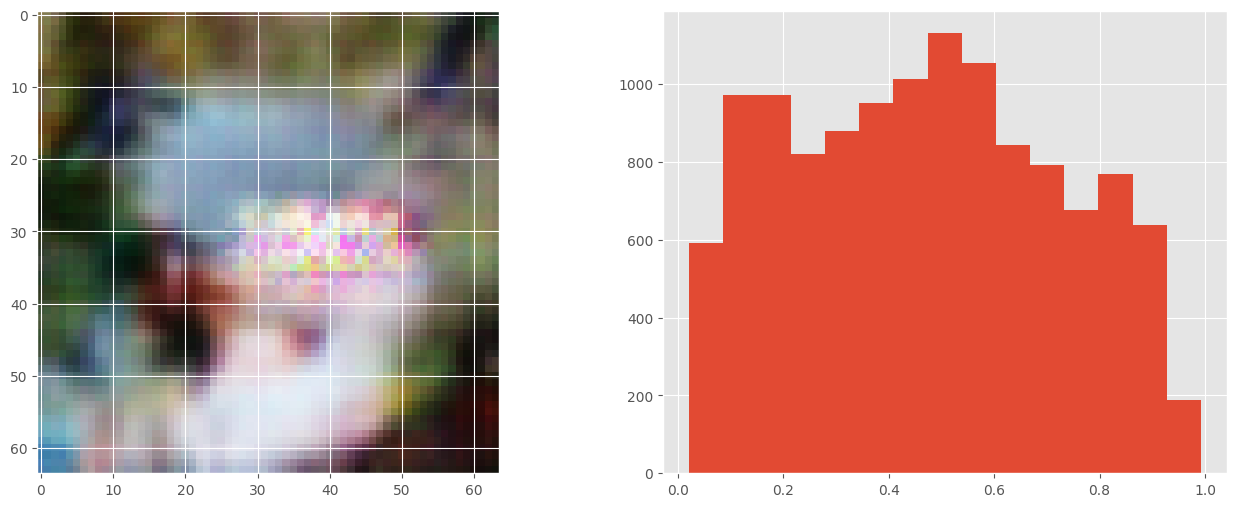

In [29]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
img = G(torch.randn(2, CFG.nz, 1, 1).to(CFG.device))
img = denorm(img[0])
img = img.permute(1, 2, 0).detach().cpu()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(img)
axs[1].hist(img[:, :, :].flatten(), bins=15)
plt.show()

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [32]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

fatal: destination path 'pytorch-gan-metrics' already exists and is not an empty directory.


In [38]:
!pip install pytorch_image_generation_metrics
!pip install pytorch-fid


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [39]:
!wget http://bioinf.jku.at/research/ttur/ttur_stats/fid_stats_cifar10_train.npz

--2025-03-13 14:20:44--  http://bioinf.jku.at/research/ttur/ttur_stats/fid_stats_cifar10_train.npz
Resolving bioinf.jku.at (bioinf.jku.at)... 140.78.90.4
Connecting to bioinf.jku.at (bioinf.jku.at)|140.78.90.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32158039 (31M) [text/plain]
Saving to: ‘fid_stats_cifar10_train.npz’

fid_stats_cifar10_t 100%[===================>]  30.67M  7.91MB/s    in 7.7s    

2025-03-13 14:20:52 (3.98 MB/s) - ‘fid_stats_cifar10_train.npz’ saved [32158039/32158039]



In [40]:
%%time
from torch.utils.data.dataset import Dataset
from pytorch_image_generation_metrics import get_inception_score_and_fid

class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim

    def __len__(self):
        return 50000

    def __getitem__(self, index):
        with torch.no_grad():
            z = torch.randn(1, self.z_dim, 1, 1).to(CFG.device)
            generated_image = self.G(z)[0].cpu()
            generated_image = denorm(generated_image)
            return generated_image

gen_dataset = GeneratorDataset(G, CFG.nz)
gen_dataloader = DataLoader(
    gen_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=0,
)

gen_res = get_inception_score_and_fid(
    gen_dataloader,
    'fid_stats_cifar10_train.npz',
)
print(f"IS: {gen_res[0][0]} +- {gen_res[0][1]}\nFID: {gen_res[1]}")

IS: 1.1135730683802243 +- 0.0010296045948793304
FID: 357.481904529149
CPU times: user 4min 25s, sys: 2.83 s, total: 4min 28s
Wall time: 4min 22s


У меня что-то сбилось и очень плохие метрики стали (до этого все было нормально (во время первого прогона), пока скидываю такой блокнот, чтобы было понятно, что я сделал, выясню, что да как и перешлю)